## X-Ray Flash Intrinsic Luminosity

In [3]:
import pandas as pd

datapath = 'Sim Data (Clusters; 800, Seed; 2639)' # all of the data is within a folder in this .ipynb file's directory
xrayData = pd.read_csv(datapath + '/AllSky Flash Data.txt', delimiter=' ')
galaxDists = pd.read_csv(datapath + '/Galaxy Distances.txt', delimiter=' ')

In [35]:
import numpy as np
equats, polars, dists = np.zeros(len(galaxDists)), np.zeros(len(galaxDists)), np.zeros(len(galaxDists))

for i in range(len(galaxDists)):
    name = galaxDists['Name'][i]
    equats[i] = name[1:6]
    polars[i] = name[8:13]
    dists[i] = galaxDists['MS_distance'][i]

In [45]:
closeflashes = xrayData.loc[xrayData['Photon-Count'] > 1e6]
print(closeflashes)

    Name  Equatorial   Polar  Photon-Count
11  FE12      201.40  105.52      34725027
32  FE33      194.73  113.83       6584428


In [49]:
lumins = []
delta = 1.5
for i, flash in closeflashes.iterrows():
    for j, equat in enumerate(equats):
        if (flash['Equatorial'] - delta <= equat <= flash['Equatorial'] + delta
           ) and (flash['Polar'] - delta <= polars[j] <= flash['Polar'] + delta):
            lumin = flash['Photon-Count'] * 4 * np.pi * dists[j]**2
            lumins.append(lumin)
lumins = np.array(lumins)
print(lumins)

[9.81580954e+14 8.06282312e+14]


## Hubble Constant and Distant Galaxies

In [52]:
base_lumin = np.mean(lumins)
xraydists = np.zeros(len(xrayData))
for i, flash in xrayData.iterrows():
    xraydists[i] = np.sqrt(base_lumin / (4 * np.pi * flash['Photon-Count']))


array([101112.53731132, 352346.45787056,  45981.2211178 , 147992.33095755,
       471489.72388147,  75335.96848001,  53624.70651076, 124969.21167463,
       106236.45426977, 105395.37641868,  98641.30947493,   1431.28435731,
       107637.35949172, 322728.16531192, 125079.09889012, 303752.61948188,
       216050.2321905 , 137165.18140845, 249037.93808431, 295258.3180916 ,
        99185.46646224, 429849.92582662, 123078.77831399, 318330.80303345,
       265128.835697  , 404857.65579624,  28713.39877234,  52175.810715  ,
       277316.9113317 , 172740.46938067, 393677.75745547,  95188.55458372,
         3286.91288867,  58073.50581439, 188126.16058023, 152870.92619691,
       148912.11812767,  87057.65123181,  19092.60415775, 288108.98996038,
        79133.07738196,  33065.8871114 , 374578.84071812,  58233.85379821,
        54147.07133104, 250682.4943962 , 140805.94891083, 115505.36332045,
       341213.82229353, 148496.09711824,  85456.56838897, 125744.56542973,
       170016.63411731, 2

In [59]:
distGalaxData = pd.read_csv(datapath + '/Distant Galaxy Data.txt', delimiter=' ')
speeds = np.zeros(len(xrayData))
delta = 0.5
for i, flash in xrayData.iterrows():
    for j, equat in enumerate(distGalaxData['Equatorial']):
        if (flash['Equatorial'] - delta <= equat <= flash['Equatorial'] + delta
           ) and (flash['Polar'] - delta <= distGalaxData['Polar'][j] <= flash['Polar'] + delta):
            speeds[i] = distGalaxData['RadialVelocity'][j]

m = 3716.17 km/s/Mpc; y-int = -4.4 km/s


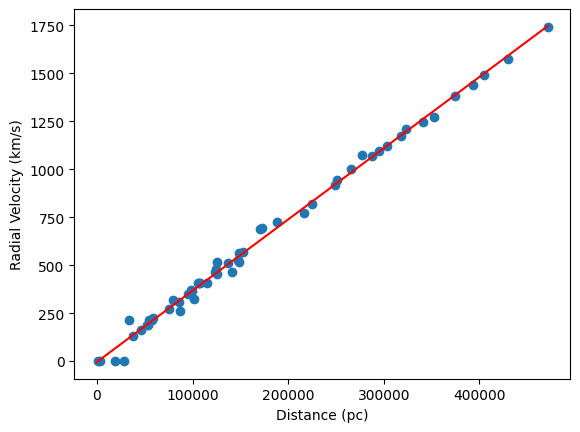

In [67]:
import matplotlib.pyplot as plt

grad, yint = np.polyfit(xraydists, speeds, 1)
xvals = np.array([0, max(xraydists)])

print(f"m = {round(grad * 1e6, 2)} km/s/Mpc; y-int = {round(yint, 2)} km/s")

fig, ax = plt.subplots()
ax.scatter(xraydists, speeds)
ax.plot(xvals, grad * xvals + yint, 'r-')
ax.set_xlabel("Distance (pc)");
ax.set_ylabel("Radial Velocity (km/s)");

In [68]:
distGalaxData['Distance'] = (distGalaxData['RadialVelocity'].to_numpy() - yint) / grad

## Is the Universe Homogeneous?
h

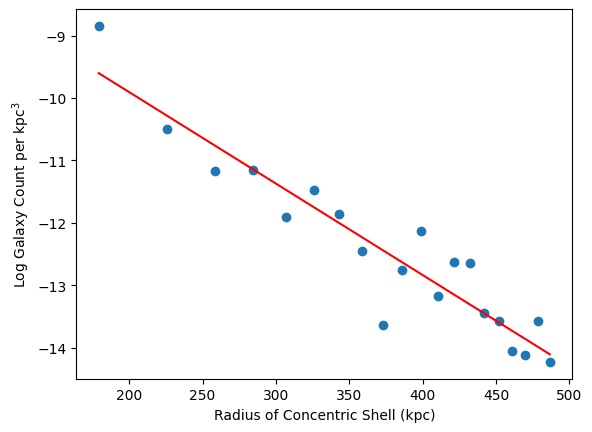

In [107]:
volume = 4 * np.pi * max(distGalaxData['Distance'])**3 / 3
subdivisions = 20
sub_vol = volume / subdivisions

radii = np.zeros(subdivisions)
for i in range(subdivisions):
    radii[i] = np.cbrt(3 * ((i + 1) * volume / subdivisions) / (4 * np.pi)) # this finds the radii for equal volume shells
    
counts = np.zeros(subdivisions)
for i, radius in enumerate(radii):
    prev = 0 if i == 0 else radii[i - 1]
    
    close_count = len(galaxDists.loc[(galaxDists['MS_distance'] > prev) & (galaxDists['MS_distance'] <= radius)])
    far_count = len(distGalaxData.loc[(distGalaxData['Distance'] > prev) & (distGalaxData['Distance'] <= radius)])
    counts[i] = close_count + far_count

grad, yint = np.polyfit(radii / 1e3, np.log(1e3**3 * counts / sub_vol), 1)

fig, ax = plt.subplots()
ax.scatter(radii / 1e3, np.log(1e3**3 * counts / sub_vol))
ax.plot(radii / 1e3, grad * radii / 1e3 + yint, 'r')
ax.set_xlabel("Radius of Concentric Shell (kpc)")
ax.set_ylabel("Log Galaxy Count per kpc$^3$");


## Galaxy Evolution?
h

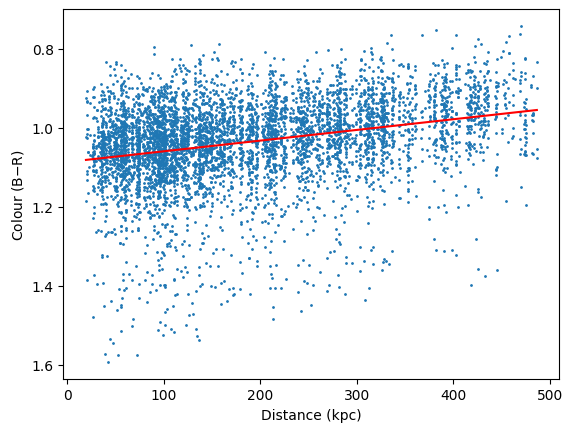

In [114]:
B_V = np.log(distGalaxData['BlueF'] / distGalaxData['RedF'])

grad, yint = np.polyfit(distGalaxData['Distance'] / 1e3, B_V, 1)
xvals = np.array([min(distGalaxData['Distance'] / 1e3), max(distGalaxData['Distance'] / 1e3)])

fig, ax = plt.subplots()
ax.scatter(distGalaxData['Distance'] / 1e3, B_V, s=1)
ax.plot(xvals, grad * xvals + yint, 'r')
ax.invert_yaxis()
ax.set_xlabel("Distance (kpc)")
ax.set_ylabel("Colour (B$-$R)");